# SUMMARY
- WHY: This simple Notebook is for me to understand who I am connected to, and thereby might reach with my posts and networking, ie:
    - What types of people (positions, industries etc) I am connected to,
    - How long I have known them
    
- HOW:
    - Analyse the Connections.csv file, as exported from LinkedIn
    - I have inferred the WHO, by using Python, REGEX and the NTLK library, to efficiently dissect strings in my connections' POSITION and COMPANY details, then count Keywords, Bigrams (word pairs), Trigrams etc
    - I also used Matplotlib and a Pareto to simply visualise those outputs

- SAMPLE OUTPUT BELOW:
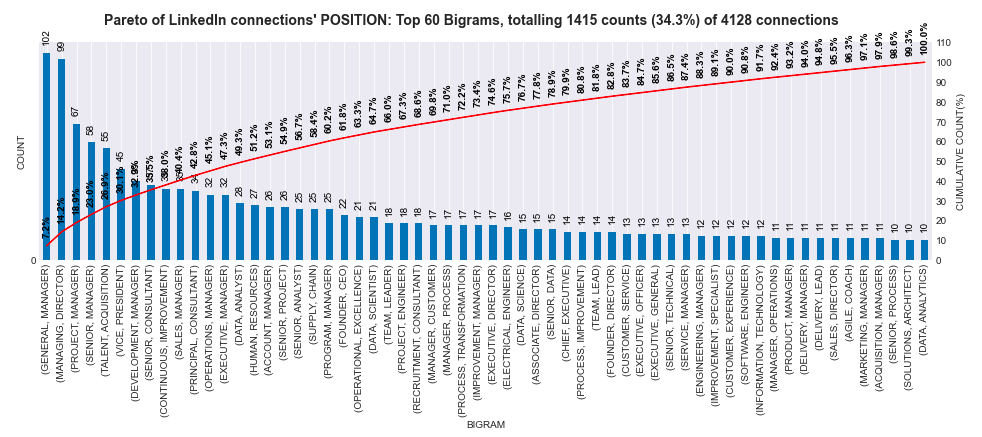

# SETUP

## Import libraries

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import math
import scipy.stats as stats
import re

import chardet
from io import BytesIO
import csv

#Import string for list of punctuation
import string
import itertools

#Import text processing libraries
import nltk
from nltk.collections import Counter
from nltk.collocations import *
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

#Libraries for plotting and setting standard plot style
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import seaborn as sns

In [2]:
#Download NLTK corpora (if needed)
#nltk.download()
#Save to: /Users/VincentMacAir/opt/anaconda3/nltk_data

## Import data

In [3]:
df = pd.read_csv('Connections.csv', skiprows = 3, parse_dates = ['Connected On'])

#Fill all the blanks
df.fillna('-', inplace = True)

#Capture size of dataframe
size_orig_df = df.shape[0]

# ENRICH DATA

## Create Year and Month columns from date-connected

In [4]:
#Create new flags: Dates
df['Connected YearMonth'] = df['Connected On'].dt.strftime('%Y%m').astype('category')
df['Connected Year'] = df['Connected On'].dt.strftime('%Y').astype('category')
df['Connected Month'] = df['Connected On'].dt.strftime('%m').astype('category')

## Consolidate names

In [5]:
#Create column that consoidates Last and First Names
df['Name'] = df['Last Name'] + ', ' + df['First Name']

#Remove lines where names = "-, -"
df = df[df['Name'] != '-, -']

#Capture size of cleaned dataframe
size_clean_df = df.shape[0]

## Consolidate companies

In [6]:
#To consolidate company names, which are inconsistent,
#first create regex to pick up key words for each company
#Eg: Company names containing "nab" upper or lower case, as well as "National... Bank" will be picked up as nab
rio = r"(?i)\brio"
uom = r"\b(?i)uni.*mel"
self = r"\b(?i)free|\b(?i)self"
telstra = r"\b(?i)Telstra"
vodafone = r"\b(?i)voda"
alstom = r"(?i)alstom"
ge = r"(?i)\bge\b|(?i)gen.*elec|(?i)granite|(?i)fieldcore|(?i)pignone"
pb = r"(?i)\bparsons|(?i)\bWSP"
bhp = r"(?i)\bbhp|(?i)billiton"
bp = r"(?i)\bbp\b|(?i)gbs|(?i)\bglobal.*bus"
nbn = r"(?i)nbn"
nab = r"(?i)\bnab|(?i)nat.*.bank"

#Create dictionary with company name and regex key-pairs
dict_co = {'RioTinto':rio,
           'University of Melbourne':uom,
           'SelfEmployed':self,
           'Telstra':telstra,
           'Vodafone':vodafone,
           'Alstom':alstom,
           'GE':ge,
           'PB':pb,
           'BHP':bhp,
           'BP':bp,
           'nbn':nbn,
           'NAB':nab}

#Test:
#df['Company'][df['Company'].str.contains(nab, regex = True)].value_counts()

In [7]:
%%script false --no-raise-error #SKIP CELL
#EXPLORATION:

reg = r"\b(?i)mining"
mask_search = df['Company'].str.contains(reg, flags=re.IGNORECASE, regex = True)

#Unlimited length
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_colwidth', None)

#display(df[mask_search][['Case Number','Case Subject and Description','First Contact Resolution']].sample(n = 10, random_state = seed))
print('Total records in-view: ' + str(df.shape[0]))
print('Number of records found: ' + str(df[mask_search].shape[0]))
print('% of found records in df: ' + str(round(df[mask_search].shape[0]/df.shape[0],3)*100) + '%')
print('')
print('SAMPLE:')
display(df['Company'][mask_search].value_counts())

#Reset options to default
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')

In [8]:
#Create blank column for consolidated company names
df['Company consolidated'] = ''

#Create flag of consolidated company names
for co in list(dict_co.keys()):
    df['Company consolidated'] = np.where(df['Company'].str.contains(dict_co[co], regex = True),
                                          co,
                                          np.where(df['Company consolidated'] == '',
                                                   df['Company'],
                                                   df['Company consolidated'])
                                         )

In [9]:
df.head()

,First Name,Last Name,Email Address,Company,Position,Connected On,Connected YearMonth,Connected Year,Connected Month,Name,Company consolidated
0,Frida,"Pellegrino, PhD",-,Impact,Data Analyst,2020-12-31,202012,2020,12,"Pellegrino, PhD, Frida",Impact
1,Paul,Faithfull CGMA CPA,paulfaithfull@aol.com,WooliesX,Senior Commercial Analyst,2020-12-31,202012,2020,12,"Faithfull CGMA CPA, Paul",WooliesX
2,Yas,Hussain,-,nbn™ Australia,Project Manager - Operations,2020-12-29,202012,2020,12,"Hussain, Yas",nbn
3,Nagendra,Koruguntla,-,Cyeint,Software Developer,2020-12-28,202012,2020,12,"Koruguntla, Nagendra",Cyeint
4,Sam,Glasson,-,National Australia Bank,Manager. Retail Monitoring.,2020-12-28,202012,2020,12,"Glasson, Sam",NAB


In [10]:
%%script false --no-raise-error #SKIP CELL
#EXPLORATION SCRIPT:
df[df['Company consolidated'] == '-'][0:50]
df['Company consolidated'].value_counts().head(20)
df[df['Company consolidated'] == 'University of Melbourne']

# EXPLORATION

## Positions: Keywords, Bigrams and Trigrams

In [11]:
#Tokenize
tokenizer = RegexpTokenizer(r"\w+")
%time df['Position (Clean)'] = df['Position'].apply(lambda x: tokenizer.tokenize(x.upper()))

CPU times: user 25.1 ms, sys: 4.82 ms, total: 30 ms
Wall time: 48.8 ms


In [12]:
#Create word_lemmatizer function
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

#Lemmatize
%time df['Position (Clean)'] = df['Position (Clean)'].apply(lambda x: word_lemmatizer(x))

CPU times: user 2.64 s, sys: 133 ms, total: 2.77 s
Wall time: 2.96 s


In [13]:
#Create remove_stopwords function
def remove_stopwords(text):
    words = [w for w in text if w not in stop]
    return words

#Define and remove stop words from list of keywords
stop = stopwords.words('english')
stop = [x.upper() for x in stop]
stop = stop + ['™','-','&','.','/',':','|','GLOBAL','NATIONAL','INTERNATIONAL','VICTORIA','MELBOURNE','ANZ','COMMONWEALTH','NEW','ZEALAND','ASIA','PACIFIC','MALAYSIA','SINGAPORE','AUSTRALIA','AUSTRALIAN','UK','PRIVATE','PLC','PTE','PT','AG','GROUP','INC','INC.','BUSINESS','CO','CO.','CO.,','CORPORATION','PTY','LTD','LTD.','LIMITED','SDN','BHD','LLC','HOLDINGS','CENTRE','DEPARTMENT','ASSOCIATION']

#Remove stopwords
%time df['Position (Clean)'] = df['Position (Clean)'].apply(lambda x: remove_stopwords(x))

CPU times: user 69.1 ms, sys: 1.06 ms, total: 70.1 ms
Wall time: 82.1 ms


In [14]:
#Create Keyword, Bigram and Trigram
df['Position Keyword'] = df['Position (Clean)'].apply(lambda row: list(nltk.ngrams(row, 1)))
df['Position Bigram'] = df['Position (Clean)'].apply(lambda row: list(nltk.ngrams(row, 2)))
df['Position Trigram'] = df['Position (Clean)'].apply(lambda row: list(nltk.ngrams(row, 3)))

Keyword_pos = list(itertools.chain(*df['Position Keyword']))
Bigram_pos = list(itertools.chain(*df['Position Bigram']))
Trigram_pos = list(itertools.chain(*df['Position Trigram']))

In [15]:
%%script false --no-raise-error #SKIP CELL
#EXPLORATION SCRIPT:
lst = Counter(Bigram_pos).most_common(50)
print(lst)
count_of_items = sum(list(list(zip(*lst))[1]))
print(count_of_items)

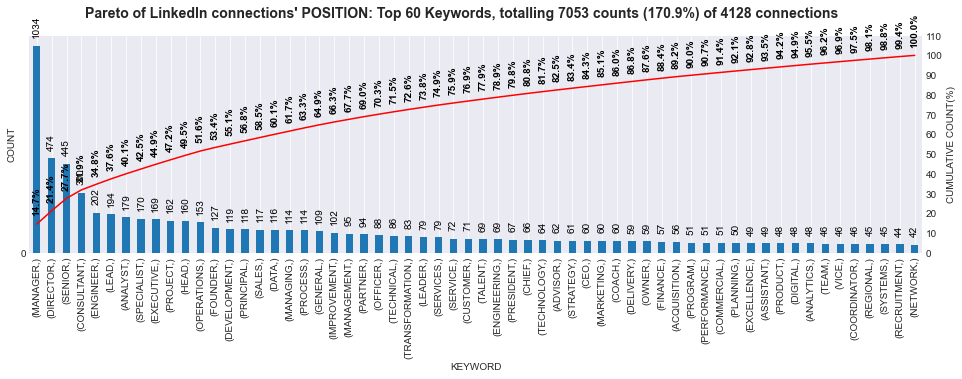

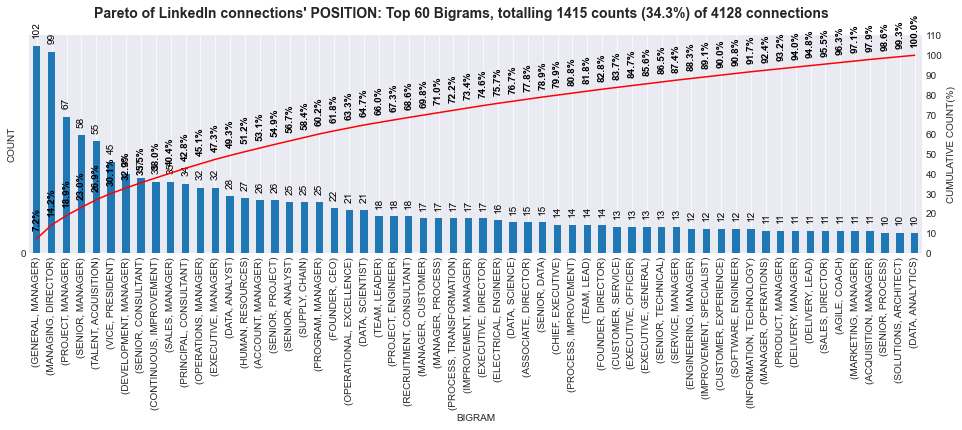

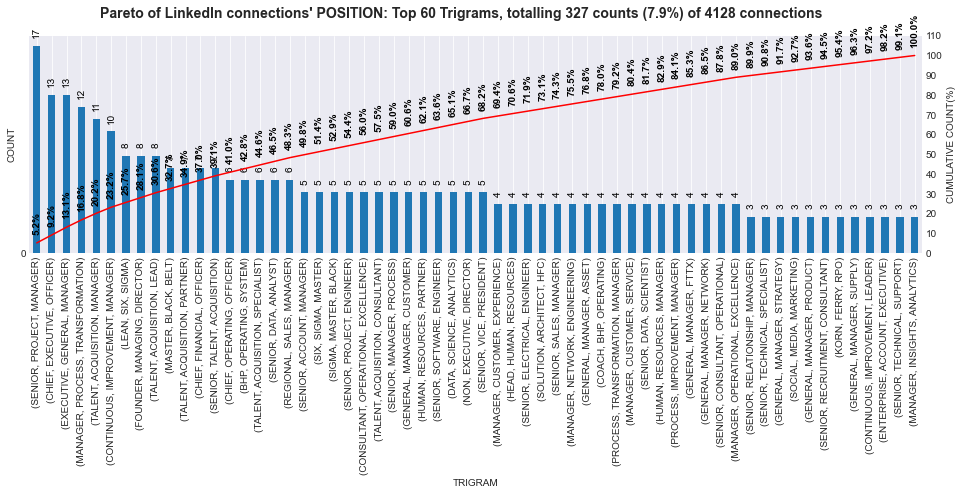

In [40]:
plot_list = {'Keyword':Keyword_pos, 'Bigram':Bigram_pos, 'Trigram':Trigram_pos}
top_count = 60

#%%script false --no-raise-error #SKIP CELL

for plot in list(plot_list.keys()):
    #Create ngram Counter variable and df to plot
    d = Counter(plot_list[plot])
    df_d = pd.DataFrame(d.most_common(top_count))
    count_items = sum(list(list(zip(*d.most_common(top_count)))[1]))
    df_d.columns = ['Keyword','Count']
    df_d.set_index('Keyword', inplace = True)
    
    #Export ngram counter as csv file
    #pd.DataFrame(index = d.keys(), data = d.values()).rename(columns = {0:'Count'}).sort_values('Count', ascending = False).to_csv(plot + ', Rev20200707.csv')
    
    #Setup plot
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(figsize=(16, 4))

    #Plot content
    ascending_order = df_d['Count'].sort_values(ascending = False).index.tolist()
    df_cumu = pd.DataFrame(df_d['Count'].sort_values(ascending = False).cumsum()/df_d['Count'].sum()*100)

    #Plot
    fig.suptitle('Pareto of LinkedIn connections\' POSITION: Top ' + str(top_count) + ' ' + plot + 's, totalling ' + str(count_items) + ' counts (' + str(round(count_items/size_clean_df * 100,1)) + '%) of '+ str(size_clean_df) + ' connections', fontsize = 14, fontweight = 'bold')
    ax2=ax.twinx()

    df_d['Count'].sort_values(ascending = False).plot(kind = 'bar', ax= ax)
    for x,y in zip(np.arange(0,df_cumu.shape[0],1),df_d['Count'].tolist()):
        label = "{:.0f}".format(y)
        ax.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center', # horizontal alignment can be left, right or center
                     size = 10,
                     #weight = 'bold',
                     rotation = 90,
                     color = 'black')

    df_cumu.plot(color = 'red', ax = ax2)
    for x,y in zip(np.arange(0,df_cumu.shape[0],1),df_cumu['Count']):
        label = "{:.1f}".format(y) +'%'
        ax2.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center', # horizontal alignment can be left, right or center
                     size = 10,
                     weight = 'bold',
                     rotation = 90,
                     color = 'black')

    ax.set(xlabel=plot.upper(), ylabel='COUNT')
    ax2.set(ylabel='CUMULATIVE COUNT(%)')

    ax.set_yticks(np.arange(0,round(df_d['Count'].max()/5000)*5000+5000,5000))
    ax2.set_yticks(np.arange(0,120,10))

    ax2.grid(False)

    ax.legend().set_visible(False)
    ax2.legend().set_visible(False)
    
    #Save the plot as png file
    #plt.savefig(plot + ', Rev20200707.png', bbox_inches='tight')

## Company: Keywords, Bigrams and Trigrams

In [17]:
#Tokenize
tokenizer = RegexpTokenizer(r"\w+")
%time df['Company (Clean)'] = df['Company consolidated'].apply(lambda x: tokenizer.tokenize(x.upper()))

CPU times: user 13 ms, sys: 1.81 ms, total: 14.8 ms
Wall time: 23.3 ms


In [18]:
#Create word_lemmatizer function
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

#Lemmatize
%time df['Company (Clean)'] = df['Company (Clean)'].apply(lambda x: word_lemmatizer(x))

CPU times: user 67.2 ms, sys: 3.21 ms, total: 70.4 ms
Wall time: 88.7 ms


In [19]:
#Create remove_stopwords function
def remove_stopwords(text):
    words = [w for w in text if w not in stop]
    return words

#Define and remove stop words from list of keywords
stop = stopwords.words('english')
stop = [x.upper() for x in stop]
stop = stop + ['™','-','&','.','/',':','|','PARTNERS','GLOBAL','NATIONAL','INTERNATIONAL','VICTORIA','MELBOURNE','ANZ','COMMONWEALTH','NEW','ZEALAND','ASIA','PACIFIC','MALAYSIA','SINGAPORE','AUSTRALIA','AUSTRALIAN','UK','PRIVATE','PLC','PTE','PT','AG','COM','PVT','GROUP','INC','INC.','BUSINESS','CO','CO.','CO.,','CORPORATION','PTY','LTD','LTD.','LIMITED','SDN','BHD','LLC','HOLDINGS','CENTRE','DEPARTMENT','ASSOCIATION','CITY']

#Remove stopwords
%time df['Company (Clean)'] = df['Company (Clean)'].apply(lambda x: remove_stopwords(x))

CPU times: user 48.8 ms, sys: 2.16 ms, total: 51 ms
Wall time: 69.6 ms


In [20]:
#Create Keyword, Bigram and Trigram
df['Company Keyword'] = df['Company (Clean)'].apply(lambda row: list(nltk.ngrams(row, 1)))
df['Company Bigram'] = df['Company (Clean)'].apply(lambda row: list(nltk.ngrams(row, 2)))
df['Company Trigram'] = df['Company (Clean)'].apply(lambda row: list(nltk.ngrams(row, 3)))

Keyword_co = list(itertools.chain(*df['Company Keyword']))
Bigram_co = list(itertools.chain(*df['Company Bigram']))
Trigram_co = list(itertools.chain(*df['Company Trigram']))

In [21]:
%%script false --no-raise-error #SKIP CELL
#EXPLORATION:
Counter(Bigrams).most_common(50)

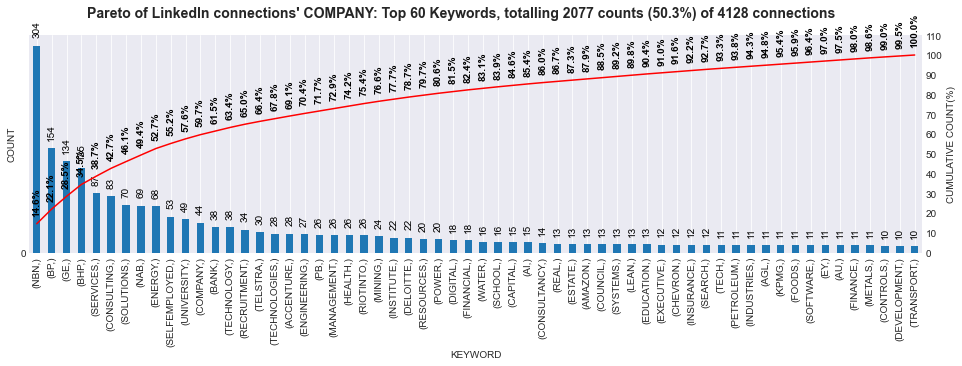

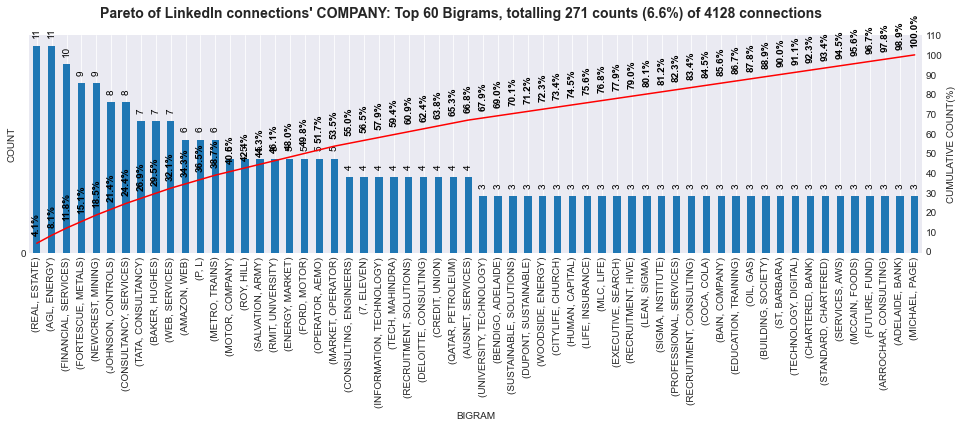

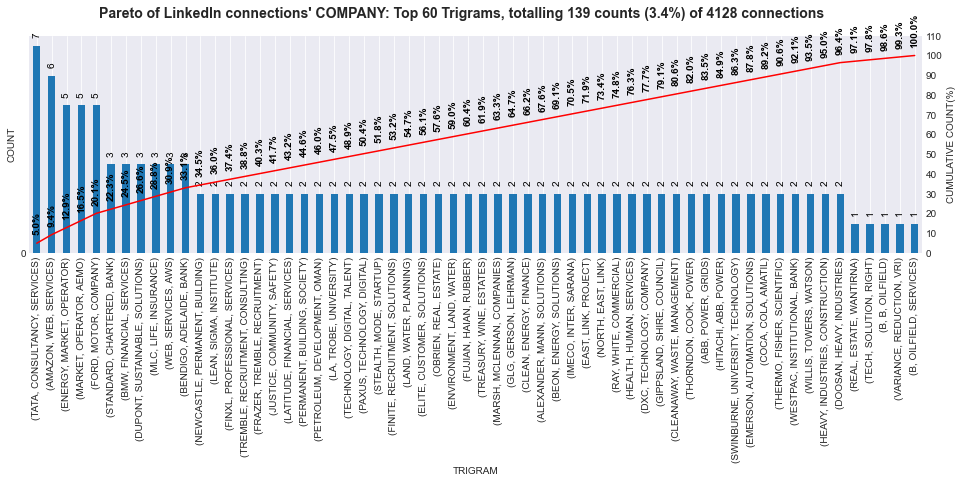

In [39]:
plot_list = {'Keyword':Keyword_co, 'Bigram':Bigram_co, 'Trigram':Trigram_co}
top_count = 60

#%%script false --no-raise-error #SKIP CELL

for plot in list(plot_list.keys()):
    #Create ngram Counter variable and df to plot
    d = Counter(plot_list[plot])
    df_d = pd.DataFrame(d.most_common(top_count))
    count_items = sum(list(list(zip(*d.most_common(top_count)))[1]))
    df_d.columns = ['Keyword','Count']
    df_d.set_index('Keyword', inplace = True)
    
    #Export ngram counter as csv file
    #pd.DataFrame(index = d.keys(), data = d.values()).rename(columns = {0:'Count'}).sort_values('Count', ascending = False).to_csv(plot + ', Rev20200707.csv')
    
    #Setup plot
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(figsize=(16, 4))

    #Plot content
    ascending_order = df_d['Count'].sort_values(ascending = False).index.tolist()
    df_cumu = pd.DataFrame(df_d['Count'].sort_values(ascending = False).cumsum()/df_d['Count'].sum()*100)

    #Plot
    fig.suptitle('Pareto of LinkedIn connections\' COMPANY: Top ' + str(top_count) + ' ' + plot + 's, totalling ' + str(count_items) + ' counts (' + str(round(count_items/size_clean_df * 100,1)) + '%) of '+ str(size_clean_df) + ' connections', fontsize = 14, fontweight = 'bold')
    ax2=ax.twinx()

    df_d['Count'].sort_values(ascending = False).plot(kind = 'bar', ax= ax)
    for x,y in zip(np.arange(0,df_cumu.shape[0],1),df_d['Count'].tolist()):
        label = "{:.0f}".format(y)
        ax.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center', # horizontal alignment can be left, right or center
                     size = 10,
                     #weight = 'bold',
                     rotation = 90,
                     color = 'black')

    df_cumu.plot(color = 'red', ax = ax2)
    for x,y in zip(np.arange(0,df_cumu.shape[0],1),df_cumu['Count']):
        label = "{:.1f}".format(y) +'%'
        ax2.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center', # horizontal alignment can be left, right or center
                     size = 10,
                     weight = 'bold',
                     rotation = 90,
                     color = 'black')

    ax.set(xlabel=plot.upper(), ylabel='COUNT')
    ax2.set(ylabel='CUMULATIVE COUNT(%)')

    ax.set_yticks(np.arange(0,round(df_d['Count'].max()/5000)*5000+5000,5000))
    ax2.set_yticks(np.arange(0,120,10))

    ax2.grid(False)

    ax.legend().set_visible(False)
    ax2.legend().set_visible(False)
    
    #Save the plot as png file
    #plt.savefig(plot + ', Rev20200707.png', bbox_inches='tight')